<a href="https://colab.research.google.com/github/danielarruda1000/ml_previsao_letalidade_rj/blob/main/TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**TCC**

**Título do Trabalho**:
Machine Learn: Modelo de previsão de taxa de letalidade violenta no estado do Rio de
Janeiro

**Resumo**: O trabalho visa aplicar 3 modelos de aprendizado de máquina e comparar as metodologias e
desempenho de cada um para prever a taxa de letalidade violenta no estado do Rio de Janeiro por 100 mil
habitantes. Os modelos aplicados para esse trabalho, são eles: Arima, Prophet e Random Forest Regressor.

Nome: Daniel Nascimento Arruda |
Email: danielarruda1000@gmail.com | 
Whatsapp: 21984088497

#### Importando bibliotecas necessárias

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import (plot_acf, plot_pacf)

sns.set(rc={'figure.figsize':(10,5)})

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%cd MyDrive/
%cd TCC

Mounted at /gdrive
/gdrive
/gdrive/MyDrive
/gdrive/MyDrive/TCC


#### Lendo os dados

In [ ]:
df = pd.read_csv('BaseEstadoTaxaMes.csv', sep=';')
df = df[['ano','mes','mes_ano','letalidade_violenta']].rename(columns={'ano':'year','mes':"month"})
df['data'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df['letalidade_violenta'] = df['letalidade_violenta'].str.replace(',','.').astype(float)

#### Analisando os dados

In [ ]:
df.dtypes

year                            int64
month                           int64
mes_ano                        object
letalidade_violenta           float64
data                   datetime64[ns]
dtype: object

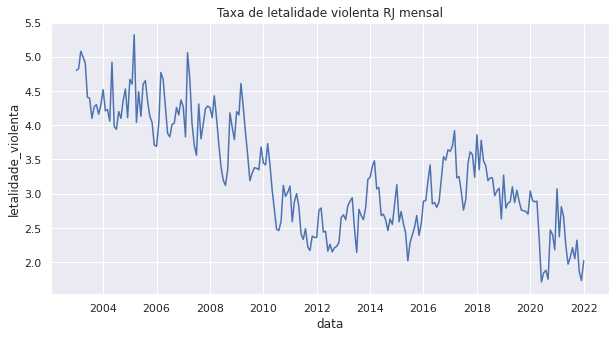

In [ ]:
sns.lineplot(data=df, x='data', y='letalidade_violenta')
plt.title('Taxa de letalidade violenta RJ mensal')
plt.show()

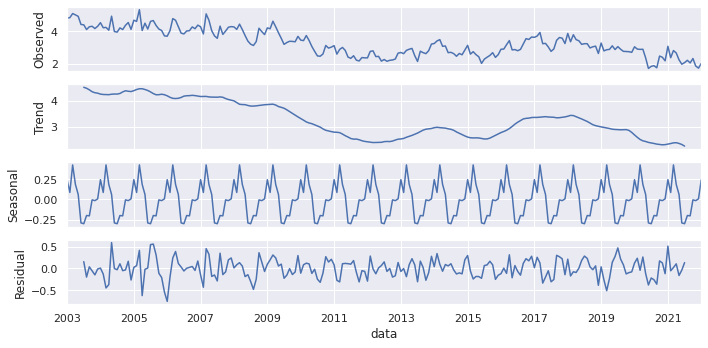

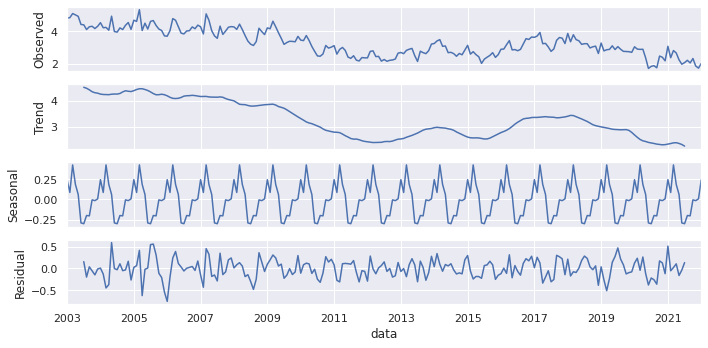

In [ ]:
## Decomposição da série temporal
seasonal_decompose(df.set_index('data')['letalidade_violenta'], model='additive').plot()

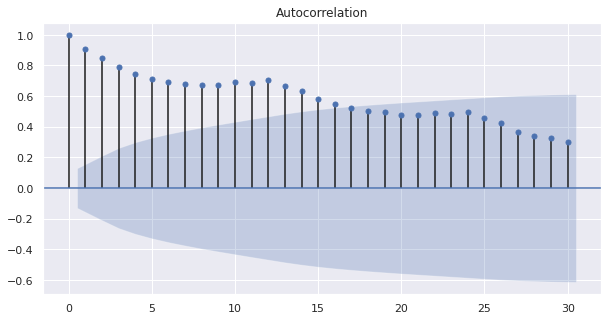

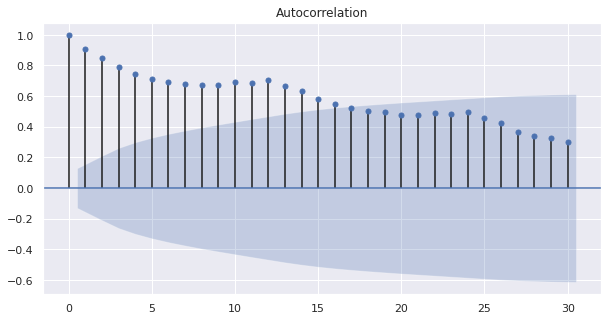

In [ ]:
plot_acf(df['letalidade_violenta'],lags=30)

### Aplicando os modelos 

#### ARIMA

### Vamos usar 1° ordem de diferenciação por estar mais estatisticamente estácionária a série

In [ ]:
# Gerando a série estacionaria com a tecnica de diferenciação (Y' em t = Y em t - Y em t-1)
df['y_linha'] = df['letalidade_violenta'].diff()
df['y_linha_diff_2'] = ((df['letalidade_violenta'] - df['letalidade_violenta'].shift(1)) -
                        (df['letalidade_violenta'].shift(1) - df['letalidade_violenta'].shift(2)))

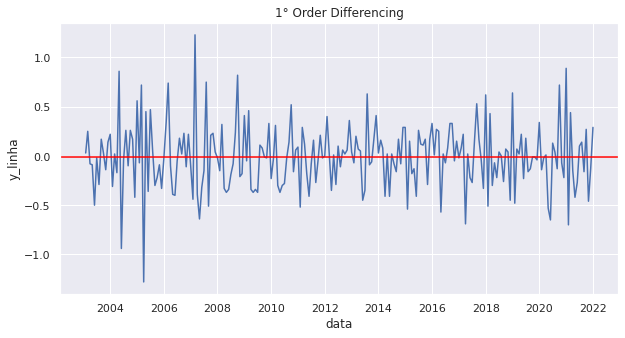

ADF Statistic: -3.87416657703761
p-value: 0.0022334104770876844
Critical Values:
	1%: -3.4612821203214907
	5%: -2.875142613826617
	10%: -2.574020122281422


In [ ]:
sns.lineplot(data=df, x='data', y='y_linha')
plt.title('1° Order Differencing')
plt.axhline(df['y_linha'].mean(), color='red')
plt.show()

# Teste para ver se a série é estacionária
result = adfuller(df['y_linha'].dropna())
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

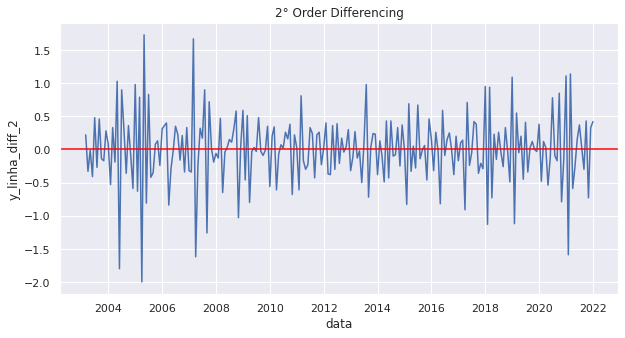

ADF Statistic: -11.235450614704202
p-value: 1.862270816046579e-20
Critical Values:
	1%: -3.4612821203214907
	5%: -2.875142613826617
	10%: -2.574020122281422


In [ ]:
sns.lineplot(data=df, x='data', y='y_linha_diff_2')
plt.title('2° Order Differencing')
plt.axhline(df['y_linha_diff_2'].mean(), color='red')
plt.show()

# Teste para ver se a série é estacionária
result = adfuller(df['y_linha_diff_2'].dropna())
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

#### Identificando os termos AR e MA do ARIMA através do ACF e PACF plot

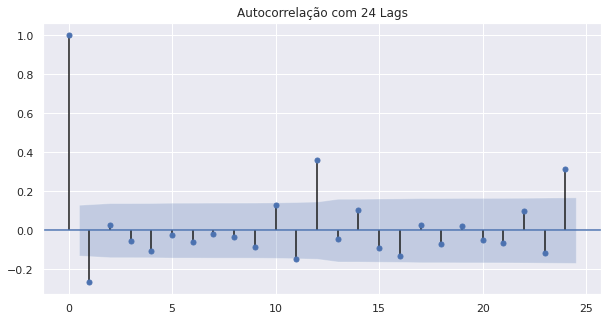

In [ ]:
plot_acf(df['y_linha'].dropna(),lags=24)
plt.title('Autocorrelação com 24 Lags')
plt.show()

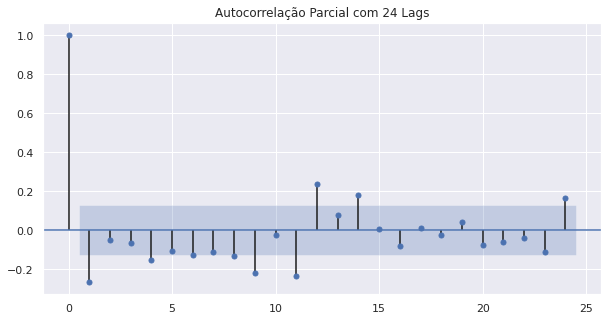

In [ ]:
plot_pacf(df['y_linha'].dropna(),lags=24)
plt.title('Autocorrelação Parcial com 24 Lags')
plt.show()

#### Ajustando o modelo ARIMA

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                               ARIMA Model Results                               
Dep. Variable:     D.letalidade_violenta   No. Observations:                  215
Model:                    ARIMA(2, 1, 2)   Log Likelihood                 -50.291
Method:                          css-mle   S.D. of innovations              0.305
Date:                   Sat, 02 Apr 2022   AIC                            112.582
Time:                           13:45:28   BIC                            132.806
Sample:                                1   HQIC                           120.754
                                                                                 
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -0.0114      0.007     -1.662      0.098      -0.025       0.002
ar.L1.D.letalidade_violenta    -0.4289      0.094     -4

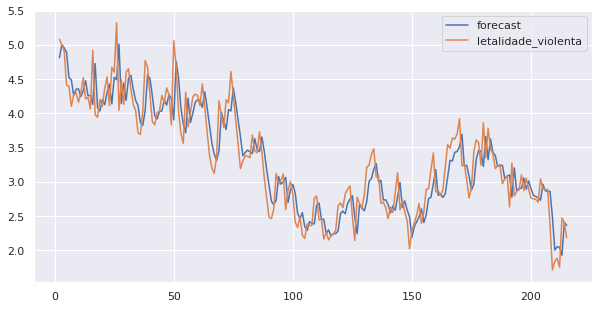

In [ ]:
# Separando dados de treino e teste
train = df['letalidade_violenta'].dropna()[:216]
test = df['letalidade_violenta'].dropna()[216:]

# Ajustando o modelo
arima_model = ARIMA(train, order=(2,1,2))
model = arima_model.fit()
print(model.summary())
model.plot_predict(dynamic=False)
plt.show()

#### Performance do modelo

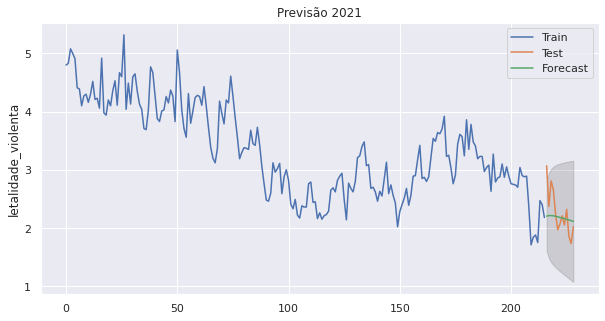

Performance do modelo
----------------------
MAPE: 11.41%
MPE: -1.5%
MAE: 0.27
RMSE: 0.36
CORR: 0.7

 Taxa de letalidade 2021
---------------------------
Taxa em 2021 real: 29.38
Taxa em 2021 prevista 28.27

Media mensal real: 2.26
Media mensal prevista 2.17


In [ ]:
# Output do modelo para 2021
fc, se, conf = model.forecast(13, alpha=0.05)

fc_series = pd.Series(fc, index = test.index)
lower_series = pd.Series(conf[:, 0], index = test.index)
upper_series = pd.Series(conf[:, 1], index = test.index)

# Plot
sns.lineplot(data=train, label='Train')
sns.lineplot(data=test, label='Test')
sns.lineplot(data=fc_series, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)
plt.title('Previsão 2021')
plt.show()

# Performance
print('Performance do modelo')
print('----------------------')
mape = np.mean(np.abs(fc_series - test)/ np.abs(test))
mpe = np.mean((fc_series - test)/(test))
mae = np.mean(np.abs(fc_series - test))
rmse = np.mean((fc_series - test)**2)**.5
corr = np.corrcoef(fc_series, test)[0,1]

print(f'MAPE: {round(mape*100,2)}%')
print(f'MPE: {round(mpe*100,2)}%')
print(f'MAE: {round(mae,2)}')
print(f'RMSE: {round(rmse, 2)}')
print(f'CORR: {round(corr, 2)}')

print('\n Taxa de letalidade 2021')
print('---------------------------')
print('Taxa em 2021 real:', test.sum())
print('Taxa em 2021 prevista', round(fc_series.sum(), 2))
print('\nMedia mensal real:', round(test.mean(),2))
print('Media mensal prevista', round(fc_series.mean(), 2))

#### Prophet

In [ ]:
!pip install pystan
!pip install fbprophet

In [ ]:
from fbprophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import add_changepoints_to_plot

In [ ]:
df_prophet = df[['data', 'letalidade_violenta']]

In [ ]:
df_prophet = df_prophet.rename(columns={'data':'ds', 'letalidade_violenta':'y'})

In [ ]:
train =  df_prophet[:216]
test =  df_prophet[216:]

In [ ]:
train

,ds,y
0,2003-01-01,4.80
1,2003-02-01,4.83
2,2003-03-01,5.08
3,2003-04-01,5.00
4,2003-05-01,4.91
...,...,...
211,2020-08-01,1.88
212,2020-09-01,1.75
213,2020-10-01,2.47
214,2020-11-01,2.40


In [ ]:
model = Prophet(changepoint_prior_scale=0.5)
model.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = model.make_future_dataframe(periods=14, freq='M')
future['ds'] = future['ds'].apply(lambda x: str(x.year) + '-' + str(x.month)+ '-' +'01')
future['ds'] = pd.to_datetime(future['ds'])
future = future.drop_duplicates()

In [ ]:
forecast = model.predict(future)

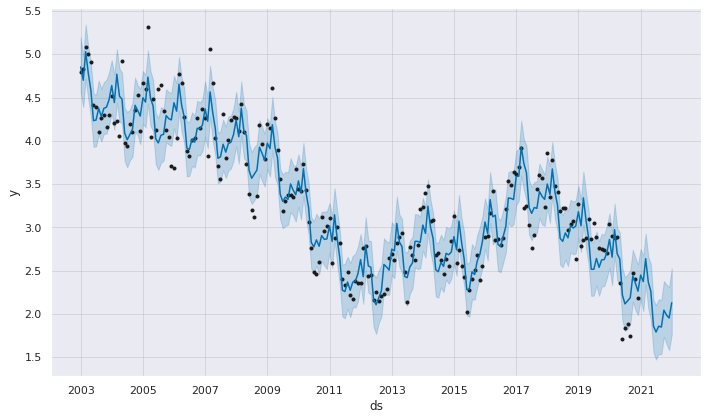

In [ ]:
fig = model.plot(forecast)

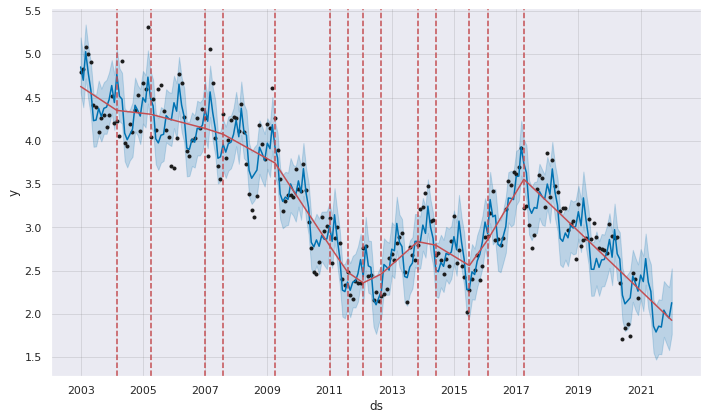

In [ ]:
a = add_changepoints_to_plot(fig.gca(),model,forecast)
fig

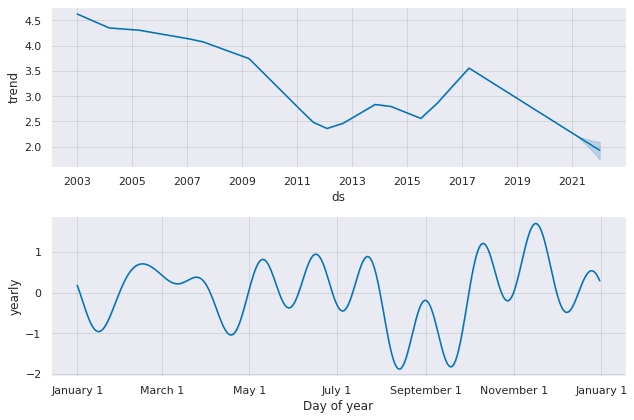

In [ ]:
fig = model.plot_components(forecast)

In [ ]:
pred = pred[pred['ds']>pd.to_datetime('2020-12-01')][['ds', 'yhat']]
validation = pd.concat([pred, test['y']],axis=1)

validation

,ds,yhat,y
216,2021-01-01,3.071179,3.07
217,2021-02-01,3.001534,2.37
218,2021-03-01,3.247862,2.81
219,2021-04-01,3.018214,2.66
220,2021-05-01,2.929550,2.24
221,2021-06-01,2.557760,1.97
222,2021-07-01,2.517376,2.07
223,2021-08-01,2.615405,2.21
224,2021-09-01,2.617084,2.05
225,2021-10-01,2.824336,2.32


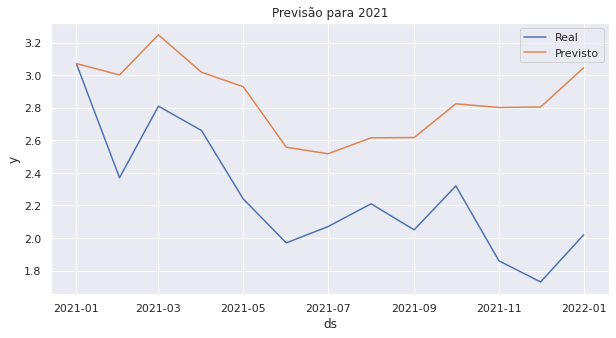

Performance do modelo
----------------------
MAPE: 28.41%
MPE: 28.41%
MAE: 0.59
RMSE: 0.65
CORR: 0.65

 Taxa de letalidade 2021
---------------------------
Taxa em 2021 real: 29.38
Taxa em 2021 prevista 37.05

Media mensal real: 2.26
Media mensal prevista 2.85


In [ ]:
sns.lineplot(data = validation, x='ds', y='y', label='Real')
sns.lineplot(data = validation, x='ds', y='yhat', label='Previsto')
plt.title('Previsão para 2021')
plt.show()

# Performance
print('Performance do modelo')
print('----------------------')
mape = np.mean(np.abs(validation['yhat'] - validation['y'])/ np.abs(validation['y']))
mpe = np.mean((validation['yhat'] - validation['y'])/(validation['y']))
mae = np.mean(np.abs(validation['yhat'] - validation['y']))
rmse = np.mean((validation['yhat'] - validation['y'])**2)**.5
corr = np.corrcoef(validation['yhat'], validation['y'])[0,1]

print(f'MAPE: {round(mape*100,2)}%')
print(f'MPE: {round(mpe*100,2)}%')
print(f'MAE: {round(mae,2)}')
print(f'RMSE: {round(rmse, 2)}')
print(f'CORR: {round(corr, 2)}')

print('\n Taxa de letalidade 2021')
print('---------------------------')
print('Taxa em 2021 real:', validation['y'].sum())
print('Taxa em 2021 prevista', round(validation['yhat'].sum(), 2))
print('\nMedia mensal real:', round(validation['y'].mean(),2))
print('Media mensal prevista', round(validation['yhat'].mean(), 2))

In [ ]:
train

,ds,y
0,2003-01-01,4.80
1,2003-02-01,4.83
2,2003-03-01,5.08
3,2003-04-01,5.00
4,2003-05-01,4.91
...,...,...
211,2020-08-01,1.88
212,2020-09-01,1.75
213,2020-10-01,2.47
214,2020-11-01,2.40


In [ ]:
cutoffs = pd.date_range(start='2010-01-01', end='2015-01-01', freq='6MS')

In [ ]:
cutoffs

DatetimeIndex(['2010-01-01', '2010-07-01', '2011-01-01', '2011-07-01',
               '2012-01-01', '2012-07-01', '2013-01-01', '2013-07-01',
               '2014-01-01', '2014-07-01', '2015-01-01'],
              dtype='datetime64[ns]', freq='6MS')

In [ ]:
df_cv = cross_validation(model=model, horizon='210 days', cutoffs=cutoffs)

  0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2010-02-01,3.629620,3.329283,3.946689,3.42,2010-01-01
1,2010-03-01,4.117934,3.817917,4.427125,3.73,2010-01-01
2,2010-04-01,3.756934,3.453880,4.065673,3.43,2010-01-01
3,2010-05-01,3.545330,3.238079,3.840971,3.06,2010-01-01
4,2010-06-01,3.118118,2.813119,3.425058,2.76,2010-01-01
...,...,...,...,...,...,...
61,2015-03-01,3.586169,3.287510,3.883358,2.74,2015-01-01
62,2015-04-01,3.419519,3.120945,3.716515,2.56,2015-01-01
63,2015-05-01,3.112403,2.808617,3.412295,2.43,2015-01-01
64,2015-06-01,2.794869,2.503425,3.074570,2.02,2015-01-01


In [ ]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,31 days,0.155659,0.394537,0.352496,0.130298,0.121013,0.134319,0.454545
1,59 days,0.204716,0.452455,0.368955,0.125758,0.126959,0.117105,0.409091
2,60 days,0.182439,0.427128,0.334924,0.112901,0.078581,0.103821,0.500000
3,62 days,0.089916,0.299860,0.254623,0.101792,0.093225,0.103649,0.500000
4,90 days,0.202773,0.450304,0.343148,0.124542,0.074370,0.118882,0.400000
5,91 days,0.201725,0.449138,0.349131,0.127253,0.111549,0.122723,0.333333
6,92 days,0.071626,0.267631,0.227744,0.087294,0.079565,0.087295,0.666667
7,120 days,0.200378,0.447636,0.391252,0.141827,0.131897,0.138498,0.466667
8,121 days,0.192837,0.439132,0.380400,0.138548,0.131897,0.135813,0.500000
9,123 days,0.096957,0.311379,0.254049,0.097976,0.060911,0.096413,0.666667


#### Random Forest Regressor